# Package imports

In [1]:
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz
import mindquantum as mq
from mindquantum.core import QubitOperator, X, Y, Z, RX, RY, RZ, Z, H, Circuit
from mindquantum.algorithm.nisq import get_qubit_hamiltonian
from algorithm import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.optimize as sopt

/home/ubuntu/anaconda3/lib/python3.7/site-packages/mindquantum/__init__.py:25: UserWarning: MindSpore not installed, you may not be able to use hybrid quantum classical neural network.
  from . import algorithm, config, core, engine, framework, io, simulator, utils


In [2]:
import mindquantum 
print(mindquantum.__version__)
import numpy 
print(numpy.__version__)
import scipy 
print(scipy.__version__)

0.8.0
1.20.1
1.6.1


# Example model

In [3]:
def ham_heis(N, J):
    ham = QubitOperator()
    for i in range(1, N):
        ham += QubitOperator("X{} X{}".format(i - 1, i), J)
        ham += QubitOperator("Y{} Y{}".format(i - 1, i), J)
        ham += QubitOperator("Z{} Z{}".format(i - 1, i), J)
    ham.compress()
    return ham

[-6.464101615137762, -3.8284271247461943, -3.8284271247461934, -3.828427124746189, -1.0000000000000018, -0.999999999999998, -0.9999999999999978, 0.4641016151377546, 1.8284271247461898, 1.82842712474619, 1.8284271247461918, 2.999999999999997, 3.0, 3.0, 3.000000000000003, 3.0000000000000036]


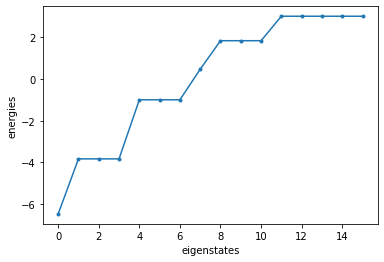

In [4]:
n_qubits = 4
ham = ham_heis(n_qubits, 1.0)
ham = ham.matrix().A
eigenenergies = sorted(np.linalg.eigvals(ham).real)
plt.plot(eigenenergies, '.-')
plt.ylabel('energies')
plt.xlabel('eigenstates')
print(eigenenergies)
plt.show()

# Folded spectrum method

In [5]:
n_qubits = 4
circ_depth = 3
single_rot_gate_seq = [RY, RZ]
ansatz = HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, depth=circ_depth).circuit

In [6]:
results = []
for approx_energy in [-6.5, -4, -1, 0.5]:
    folded = Folded_spectrum(n_qubits=n_qubits, ansatz=ansatz, ham=ham_heis(n_qubits, 1.0), target_energy=approx_energy)    
    np.random.seed(100)
    init_params = np.random.rand(len(ansatz.params_name)) - 0.5
    res = sopt.minimize(folded.evaluate,
                        init_params,
                        method='l-bfgs-b',
                        jac=True,
                        options={'disp': False})
    results.append(folded.energy(res.x))
    

In [7]:
results

[-6.464101609059055,
 -3.8284270983054305,
 -1.0000000775643823,
 0.464101615290512]

Text(0, 0.5, 'energy')

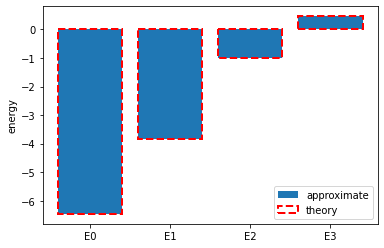

In [8]:
theo_result = [-6.464101615137754, -3.8284271247461867, -1, 0.4641016151377547]
plt.bar(range(len(results)), results, label='approximate', tick_label=['E0', 'E1', 'E2', 'E3'])
plt.bar(range(len(results)), theo_result, ec='red', ls='--', lw=2, fill='', label='theory')
plt.legend()
plt.ylabel('energy')


# Orthogonally constrained VQE

In [9]:
n_qubits = 4
circ_depth = 3
single_rot_gate_seq = [RY, RZ]
ansatz = HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, depth=circ_depth).circuit

In [10]:
orthogonally = Orthogonally_constrained(n_qubits, ham_heis(n_qubits, 1.0))
orthogonally.initial_next_eigenstate(ansatz, 1, [])  
results = []
for i in range(8):
    np.random.seed(100)
    init_params = np.random.rand(len(ansatz.params_name)) - 0.5
    res = sopt.minimize(orthogonally.evaluate,
                        init_params,
                        method='l-bfgs-b',
                        jac=True,
                        options={'disp': False})
    results.append(orthogonally.energy(res.x))
    ansatz = HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, depth=circ_depth).circuit    
    orthogonally.initial_next_eigenstate(ansatz, 10, res.x)
print(results)


[-6.46410159616838, -3.8284266495180868, -3.8284269700235116, -3.8283900642682296, -1.000000301665709, -0.9999997512941728, -1.0000008871983281, 0.4641005064058035]


Text(0, 0.5, 'energy')

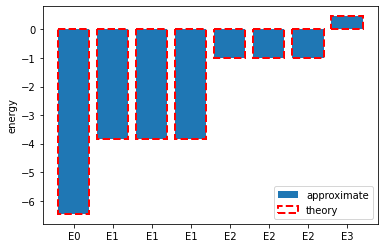

In [11]:
theo_result = [-6.464101615137754, -3.8284271247461867, -3.8284271247461867, -3.8284271247461867, -1, -1, -1, 0.4641016151377547]
plt.bar(range(len(results)), results, label='approximate', tick_label=['E0', 'E1', 'E1', 'E1', 'E2', 'E2', 'E2', 'E3'])
plt.bar(range(len(results)), theo_result, ec='red', ls='--', lw=2, fill='', label='theory')
plt.legend()
plt.ylabel('energy')


# Subspace expansion

In [12]:
n_qubits = 4
circ_depth = 3
single_rot_gate_seq = [RY, RZ]
ansatz = HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, depth=circ_depth).circuit

In [13]:
excitation_ops = []
excitation_ops.append(QubitOperator(f''))
for i in range(n_qubits):
    excitation_ops.append(QubitOperator(f'X{i}'))
    excitation_ops.append(QubitOperator(f'Y{i}'))
    excitation_ops.append(QubitOperator(f'Z{i}'))


In [14]:
subspace_expansion = Subspace_expansion(n_qubits, ansatz, ham_heis(n_qubits, 1.0), excitation_ops)

In [15]:
np.random.seed(100)
init_params = np.random.rand(len(ansatz.params_name)) - 0.5
res = sopt.minimize(subspace_expansion.evaluate,
                    init_params,
                    method='l-bfgs-b',
                    jac=True,
                    options={'disp': False})
print(subspace_expansion.energy(res.x))

-6.46410159616838


In [16]:
ham_sub, s_mat = subspace_expansion.evaluate_matrics(res.x)
energies = sorted(sp.linalg.eigvals(ham_sub, s_mat))

In [17]:
energies

[(-6.46410160596924+0j),
 (-3.8284271218145225+0j),
 (-3.8284271180536567+0j),
 (-3.8284271057772092+0j),
 (-1.000000003711563+0j),
 (-1.0000000015929928+0j),
 (-0.9999999973739893+0j),
 (0.6732998149724728+0j),
 (1.2526976439098478+0j),
 (1.8284271144846993+0j),
 (1.8284271276704949+0j),
 (1.8284271307607851+0j),
 (2.8893834003522274+0j)]

In [18]:
results = energies[:7]

/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'energy')

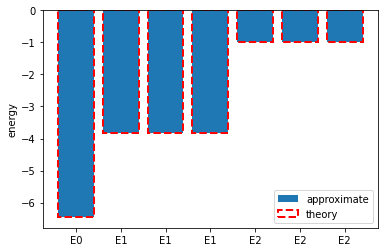

In [19]:
theo_result = [-6.464101615137754, -3.8284271247461867, -3.8284271247461867, -3.8284271247461867, -1, -1, -1, 0.4641016151377547]
tick_label = ['E0', 'E1', 'E1', 'E1', 'E2', 'E2', 'E2', 'E3']
plt.bar(range(len(results)), results, label='approximate', tick_label=tick_label[:len(results)])
plt.bar(range(len(results)), theo_result[:len(results)], ec='red', ls='--', lw=2, fill='', label='theory')
plt.legend()
plt.ylabel('energy')

# Subspace-search VQE

In [20]:
n_qubits = 4
circ_depth = 15
single_rot_gate_seq = [RY, RZ]
ansatz = HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, depth=circ_depth).circuit

In [21]:
init_circs = []
k = 8
for i in range(k):
    bin_str = f'{{:0{n_qubits}b}}'.format(i)
    tmp_circ = Circuit()
    for j, c in enumerate(bin_str):
        if c == '1':
            tmp_circ += X.on(j)
    init_circs.append(tmp_circ)

In [22]:
subspace_search = Subspace_search(n_qubits, init_circs, ansatz, ham_heis(n_qubits, 1.0), k)
np.random.seed(142)
init_params = np.random.rand(len(ansatz.params_name)) - 0.5
res = sopt.minimize(subspace_search.evaluate,
                    init_params,
                    method='l-bfgs-b',
                    jac=True,
                    options={'disp': False})
results = subspace_search.energy(res.x)
print(results)


[-6.464101011184937, -3.8284264450878784, -3.8284246587013566, -3.8283970094273885, -1.0000277154921262, -1.0000006357720561, -0.9999939346788475, 0.46412509122027806]


Text(0, 0.5, 'energy')

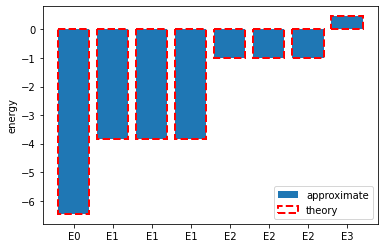

In [23]:
theo_result = [-6.464101615137754, -3.8284271247461867, -3.8284271247461867, -3.8284271247461867, -1, -1, -1, 0.4641016151377547]
tick_label = ['E0', 'E1', 'E1', 'E1', 'E2', 'E2', 'E2', 'E3']
plt.bar(range(len(results)), results, label='approximate', tick_label=tick_label[:len(results)])
plt.bar(range(len(results)), theo_result[:len(results)], ec='red', ls='--', lw=2, fill='', label='theory')
plt.legend()
plt.ylabel('energy')


# Multistate contracted VQE

In [24]:
n_qubits = 4
circ_depth = 8
single_rot_gate_seq = [RY, RZ]
ansatz = HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, depth=circ_depth).circuit

In [25]:
init_circs = []
k = 4
for i in range(k):
    bin_str = f'{{:0{n_qubits}b}}'.format(i)
    tmp_circ = Circuit()
    for j, c in enumerate(bin_str):
        if c == '1':
            tmp_circ += X.on(j)
    init_circs.append(tmp_circ)

In [26]:
multistate_constracted = Multistate_constracted(n_qubits, init_circs, ansatz, ham_heis(n_qubits, 1.0), k)
np.random.seed(514)
init_params = np.random.rand(len(ansatz.params_name)) - 0.5
res = sopt.minimize(multistate_constracted.evaluate,
                    init_params,
                    method='l-bfgs-b',
                    jac=True,
                    options={'disp': False})
results = multistate_constracted.energy(res.x)
print(results)


[-3.8743765919922915, -3.9160236915995084, -4.689398355444785, -5.469526452854694]


In [27]:
ham_sub = multistate_constracted.evaluate_matrics(res.x)
approx_result = sorted(sp.linalg.eigvalsh(ham_sub))
print(approx_result)

[-6.463973918449323, -3.828522007786619, -3.828414721960792, -3.828414443694544]


Text(0, 0.5, 'energy')

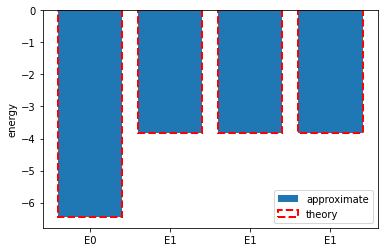

In [28]:
theo_result = [-6.464101615137754, -3.8284271247461867, -3.8284271247461867, -3.8284271247461867, -1, -1, -1, 0.4641016151377547]
tick_label = ['E0', 'E1', 'E1', 'E1', 'E2', 'E2', 'E2', 'E3']
plt.bar(range(len(approx_result)), approx_result, label='approximate', tick_label=tick_label[:len(approx_result)])
plt.bar(range(len(approx_result)), theo_result[:len(approx_result)], ec='red', ls='--', lw=2, fill='', label='theory')
plt.legend()
plt.ylabel('energy')


# Orthogonal State Reduction Variational Eigensolver

In [29]:
n_qubits = 4
circ_depth = 3
single_rot_gate_seq = [RY, RZ]
ansatz = HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, depth=circ_depth).circuit


In [30]:
orthogonally = Orthogonal_state_reduction(n_qubits, '1100', ham_heis(n_qubits, 1.0))
orthogonally.initial_next_eigenstate(ansatz, [])
results = []
for i in range(7):
    np.random.seed(100)
    init_params = np.random.rand(len(ansatz.params_name)) - 0.5
    res = sopt.minimize(orthogonally.evaluate,
                        init_params,
                        method='l-bfgs-b',
                        jac=True,
                        options={'disp': True})
    results.append(orthogonally.energy(res.x))
    ansatz = HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, depth=circ_depth).circuit
    orthogonally.initial_next_eigenstate(ansatz, res.x)
print(results)


[-6.464101543692045, -3.828427081068745, -3.828427069408479, -3.828426957431073, -1.0000000329991128, -1.000000023124102, -0.9999999692994048]


Text(0, 0.5, 'energy')

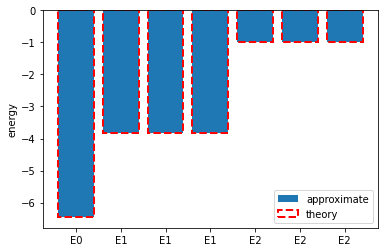

In [31]:
theo_result = [-6.464101615137754, -3.8284271247461867, -3.8284271247461867, -3.8284271247461867, -1, -1, -1, 0.4641016151377547]
tick_label = ['E0', 'E1', 'E1', 'E1', 'E2', 'E2', 'E2', 'E3']
plt.bar(range(len(results)), results, label='approximate', tick_label=tick_label[:len(results)])
plt.bar(range(len(results)), theo_result[:len(results)], ec='red', ls='--', lw=2, fill='', label='theory')
plt.legend()
plt.ylabel('energy')